# Project: Used Car Estimator (Numerical Methods)

Rusty Bargain, a used car sales service, is developing an app to attract new customers. In that app, users can quickly find out the market value of their car. We have access to historical data: technical specifications, trim versions, and prices. We need to build the model to determine the value.

Our client is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb

In [2]:
try:
    df = pd.read_csv('datasets/car_data.csv')
except:
    df = pd.read_csv('/datasets/car_data.csv')

In [3]:
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
5,04/04/2016 17:36,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,04/04/2016 00:00,0,33775,06/04/2016 19:17
6,01/04/2016 20:48,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,01/04/2016 00:00,0,67112,05/04/2016 18:18
7,21/03/2016 18:54,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,21/03/2016 00:00,0,19348,25/03/2016 16:47
8,04/04/2016 23:42,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,04/04/2016 00:00,0,94505,04/04/2016 23:42
9,17/03/2016 10:53,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,17/03/2016 00:00,0,27472,31/03/2016 17:17


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
total_count = len(df)

for column in df.columns:
    column_count = df[column].count()
    count_percentage = (column_count / total_count) * 100
    print(f'{column}: {count_percentage:.2f}%')

DateCrawled: 100.00%
Price: 100.00%
VehicleType: 89.42%
RegistrationYear: 100.00%
Gearbox: 94.40%
Power: 100.00%
Model: 94.44%
Mileage: 100.00%
RegistrationMonth: 100.00%
FuelType: 90.72%
Brand: 100.00%
NotRepaired: 79.92%
DateCreated: 100.00%
NumberOfPictures: 100.00%
PostalCode: 100.00%
LastSeen: 100.00%


In [6]:
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


So far in inspecting the data, we see some discrepancies in the counts against the expected totals (i.e. missing values for VehicleType, Gearbox, Model, FuelType, NotRepaired). Also, the min and max values for RegistrationYear (1000 and 9999, respectively) don't seem to be valid. We'll want to take care of this below.

In [7]:
# Find duplicated values
df.duplicated().sum()

262

In [8]:
# Drop duplicated values
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

In [9]:
# Drop data that can't be used for prediction
df = df.drop(['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen'], axis=1)

<Axes: xlabel='RegistrationYear'>

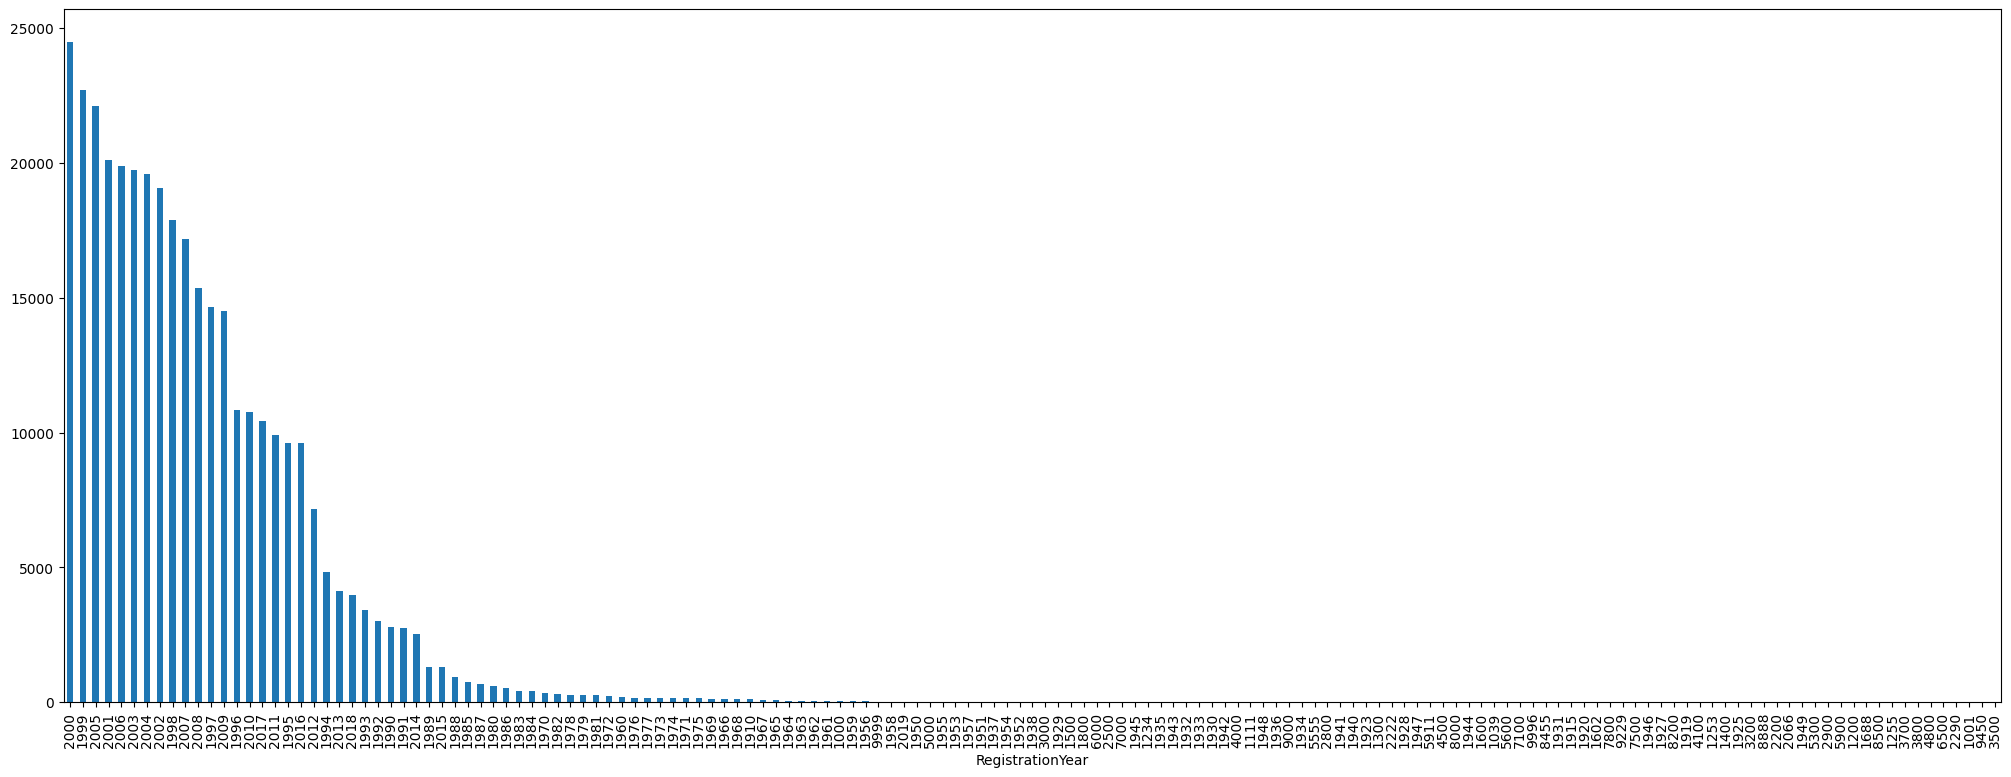

In [10]:
plt.figure(figsize=(25, 9))
df['RegistrationYear'].value_counts().plot(kind='bar')

In [11]:
# Handle outliers
df.loc[(df['RegistrationYear'] < 1910) | (df['RegistrationYear'] > 2019)] = np.nan

<Axes: xlabel='RegistrationYear'>

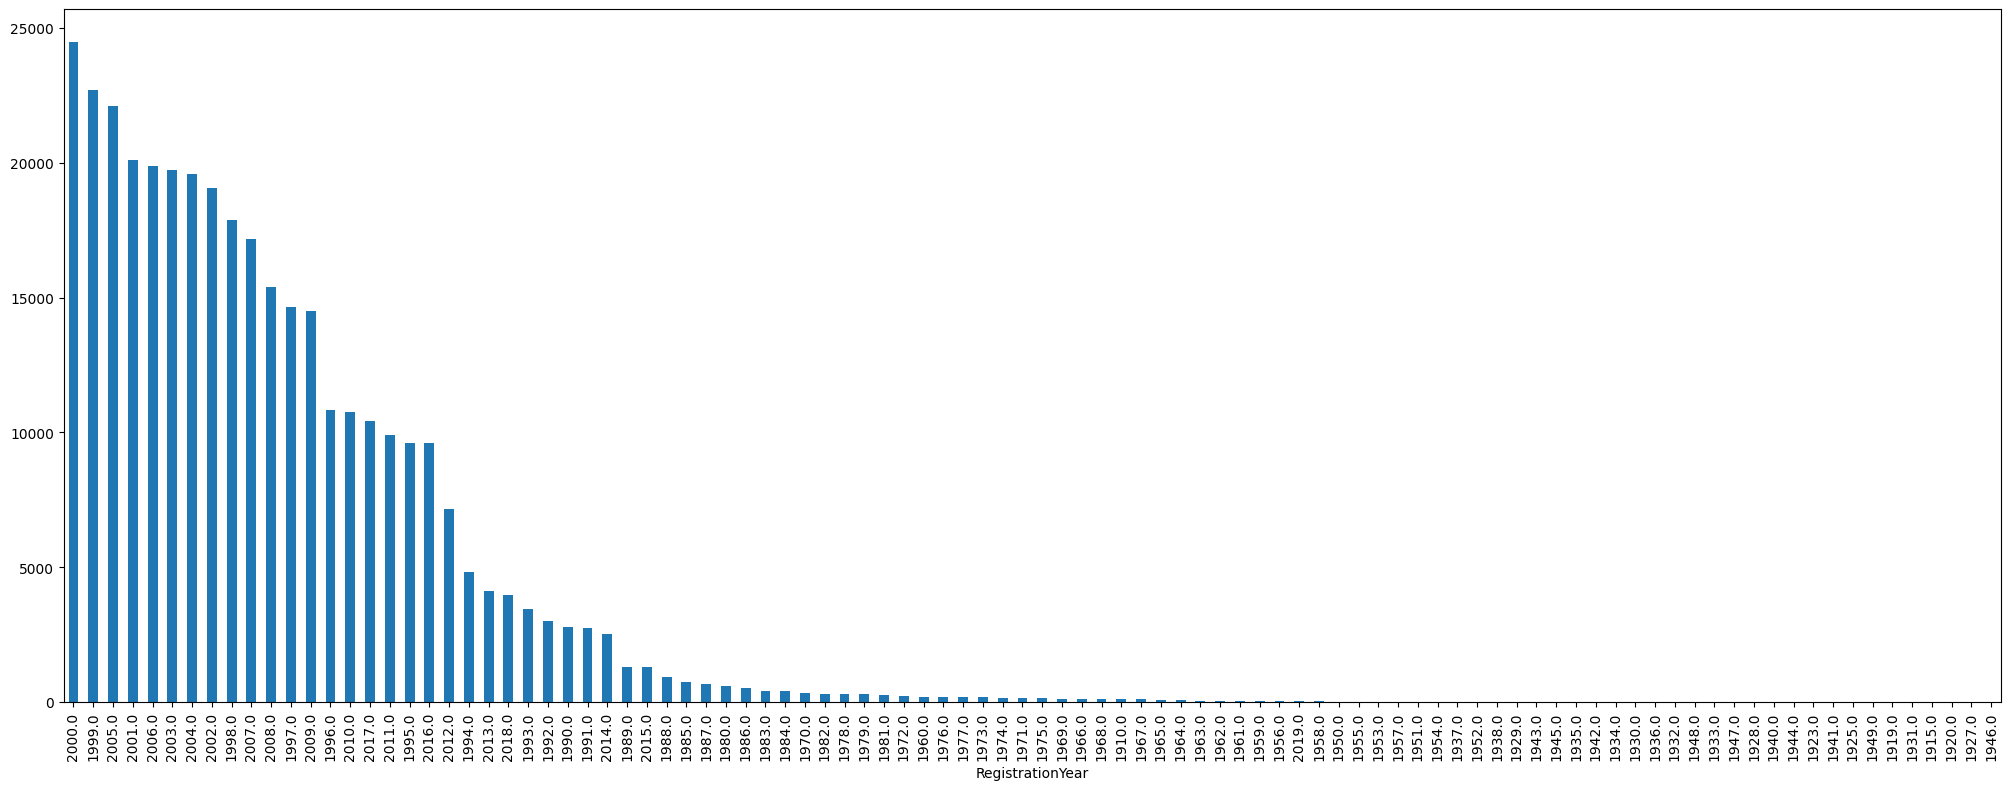

In [12]:
plt.figure(figsize=(25, 9))
df['RegistrationYear'].value_counts().plot(kind='bar')

In cleaning our data, we drop duplicate values, as well as data that won't be useful for prediction, and handle outliers for RegistrationYear by converting them to NaN.

In [13]:
# Check for missing values
df.isnull().sum()

Price                  171
VehicleType          37484
RegistrationYear       171
Gearbox              19863
Power                  171
Model                19797
Mileage                171
RegistrationMonth      171
FuelType             32932
Brand                  171
NotRepaired          71169
NumberOfPictures       171
dtype: int64

In [14]:
cat_features = [
    'VehicleType',
    'Gearbox',
    'Model',
    'FuelType',
    'Brand',
    'NotRepaired'
]

for feature in cat_features:
    print(f'{feature}: {df[feature].value_counts().count()}')

VehicleType: 8
Gearbox: 2
Model: 250
FuelType: 7
Brand: 40
NotRepaired: 2


In [15]:
# Fill in missing values
df[cat_features] = df[cat_features].fillna('unknown')

In [16]:
df = df.dropna()
df.isnull().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Mileage              0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
NumberOfPictures     0
dtype: int64

<Axes: >

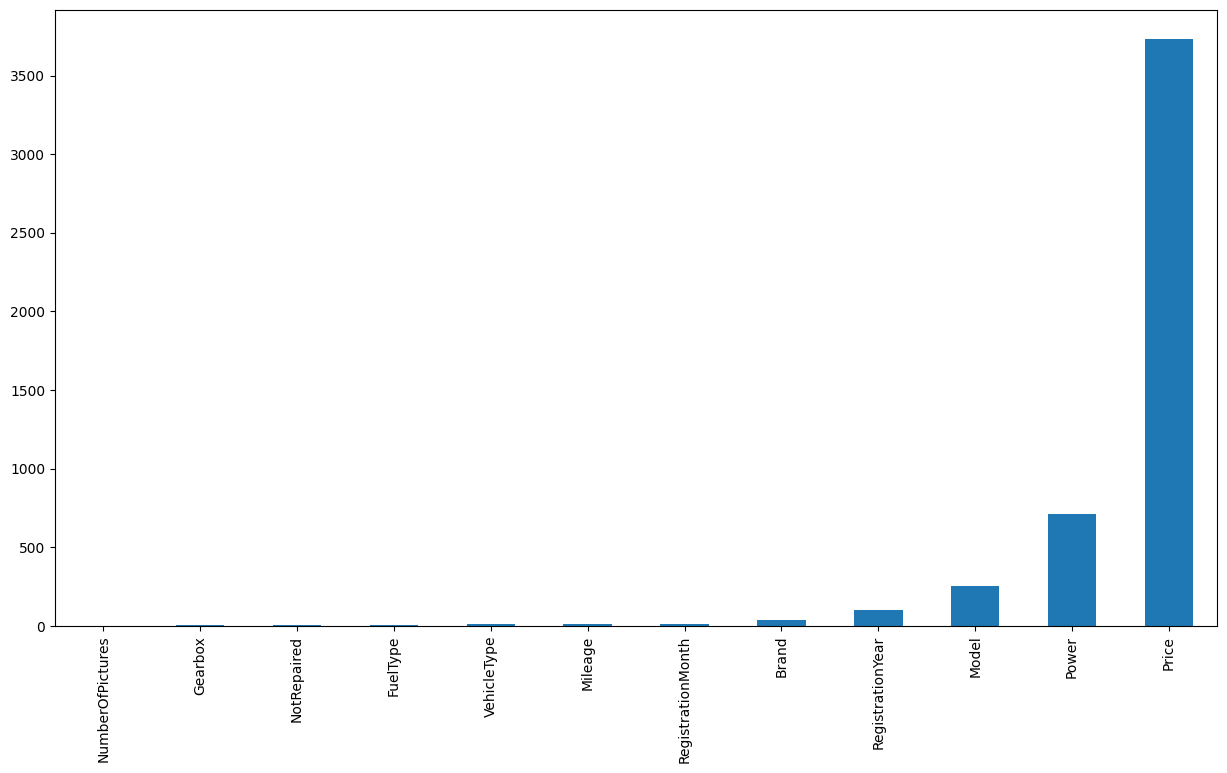

In [17]:
# Use a plot to see if we want to drop any categories that have
# an excessive amount of data that might slow things down
plt.figure(figsize=(15, 8))
df.nunique().sort_values().plot(kind='bar')

We find missing values, establish our categorical features for encoding, fill in missing values, drop NaN values, and assess the dataframe for any categories to drop that might have an excessive amount of data and slow down model training, etc. Price has the most data compared to the other categories, but since it will be used as our target for machine learning, we leave this alone for now.

## Model training

### Feature encoding

In [18]:
# OHE encoding
df_ohe = df.drop(['Model', 'Brand'], axis=1) # drop categories with a lot of data
df_ohe = pd.get_dummies(df_ohe, columns=['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired'], drop_first=True, dtype='int')
print(df_ohe.shape)
df_ohe.head(10)

(353936, 25)


,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,Gearbox_unknown,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,FuelType_unknown,NotRepaired_unknown,NotRepaired_yes
0,480.0,1993.0,0.0,150000.0,0.0,0.0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,18300.0,2011.0,190.0,125000.0,5.0,0.0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
2,9800.0,2004.0,163.0,125000.0,8.0,0.0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,1500.0,2001.0,75.0,150000.0,6.0,0.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,3600.0,2008.0,69.0,90000.0,7.0,0.0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,650.0,1995.0,102.0,150000.0,10.0,0.0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
6,2200.0,2004.0,109.0,150000.0,8.0,0.0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,0.0,1980.0,50.0,40000.0,7.0,0.0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
8,14500.0,2014.0,125.0,30000.0,8.0,0.0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
9,999.0,1998.0,101.0,150000.0,0.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [19]:
# Ordinal encoding
df_ord = df.copy() # use the full dataframe this time
df_ord[cat_features] = OrdinalEncoder().fit_transform(df[cat_features])
print(df_ord.shape)
df_ord.head(10)

(353936, 12)


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,NumberOfPictures
0,480.0,7.0,1993.0,1.0,0.0,116.0,150000.0,0.0,6.0,38.0,1.0,0.0
1,18300.0,2.0,2011.0,1.0,190.0,228.0,125000.0,5.0,2.0,1.0,2.0,0.0
2,9800.0,6.0,2004.0,0.0,163.0,117.0,125000.0,8.0,2.0,14.0,1.0,0.0
3,1500.0,5.0,2001.0,1.0,75.0,116.0,150000.0,6.0,6.0,38.0,0.0,0.0
4,3600.0,5.0,2008.0,1.0,69.0,101.0,90000.0,7.0,2.0,31.0,0.0,0.0
5,650.0,4.0,1995.0,1.0,102.0,11.0,150000.0,10.0,6.0,2.0,2.0,0.0
6,2200.0,1.0,2004.0,1.0,109.0,8.0,150000.0,8.0,6.0,25.0,0.0,0.0
7,0.0,4.0,1980.0,1.0,50.0,166.0,40000.0,7.0,6.0,38.0,0.0,0.0
8,14500.0,0.0,2014.0,1.0,125.0,60.0,30000.0,8.0,6.0,10.0,1.0,0.0
9,999.0,5.0,1998.0,1.0,101.0,116.0,150000.0,0.0,7.0,38.0,1.0,0.0


Based on a previous look at our our categorical features counts, we drop two categories with the most data (Model, Brand) before running OHE encoding on the rest of the categorical features. We also run ordinal encoding for the entire categorical features set so that we have the appropriate encoded data to work with in anticipation of training different models.

### Feature preparation

In [20]:
# Split the data
features = df.drop(['Price'], axis=1)
target = df['Price']

features_train, features_remaining, target_train, target_remaining = train_test_split(features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_remaining, target_remaining, test_size=0.5, random_state=12345)

# OHE encoding
features_ohe = df_ohe.drop(['Price'], axis=1)
target_ohe = df_ohe['Price']

features_train_ohe, features_remaining_ohe, target_train_ohe, target_remaining_ohe = train_test_split(features_ohe, target_ohe, test_size=0.4, random_state=12345)
features_valid_ohe, features_test_ohe, target_valid_ohe, target_test_ohe = train_test_split(features_remaining_ohe, target_remaining_ohe, test_size=0.5, random_state=12345)

# Ordinal encoding
features_ord = df_ord.drop(['Price'], axis=1)
target_ord = df_ord['Price']

features_train_ord, features_remaining_ord, target_train_ord, target_remaining_ord = train_test_split(features_ord, target_ord, test_size=0.4, random_state=12345)
features_valid_ord, features_test_ord, target_valid_ord, target_test_ord = train_test_split(features_remaining_ord, target_remaining_ord, test_size=0.5, random_state=12345)

### Model selection, tuning, and training

In [21]:
def rmse(y, a):
    return mean_squared_error(y, a) ** 0.5

In [22]:
# TODO: use scoring='neg_root_mean_squared_error' instead
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [23]:
def tune_hyperparameters(model, param_grid, features, target, cat_features=None):
    gs = GridSearchCV(
        model,
        param_grid=param_grid,
        scoring=rmse_scorer,
        verbose=2
    )

    if cat_features is None:
        gs.fit(features, target)
    else:
        gs.fit(
            features,
            target,
            categorical_feature=cat_features
        )
    
    print(f'Best RMSE score: {-gs.best_score_:.2f}')
    print(f'Best params: {gs.best_params_}')

In [24]:
def evaluate_model(regressor, X_train, y_train, X_test, y_test, params=None, cat_features=None, eval_set=False):
    start_time = time.time()

    if params is None:
        model = regressor()
    else:
        model = regressor(**params)

    if cat_features is not None:
        model.fit(
            X_train,
            y_train,
            categorical_feature=cat_features
        )
    elif eval_set:
        model.fit(
            X_train,
            y_train,
            eval_set=(X_test, y_test)
        )
    else:
        model.fit(X_train, y_train)
    
    end_time = time.time()
    training_time = end_time - start_time

    start_time_predict = time.time()

    pred_test = model.predict(X_test)

    end_time_predict = time.time()
    prediction_time = end_time_predict - start_time_predict

    print(f'RMSE score: {rmse(y_test, pred_test):.2f}')
    print(f'Training time: {training_time:.2f}s')
    print(f'Prediction time: {prediction_time:.2f}s')

We establish a few functions, including one for RMSE calculation (plus creating a RMSE scorer for GridSearchCV), one for hyperparamter tuning, and one for model evaluation.

#### Dummy (Baseline)

In [25]:
# TODO: the mean should be calculated on training set instead
pred_mean = np.ones(target_test.shape) * target_test.mean()
print(f"Baseline RMSE score: {rmse(target_test, pred_mean):.2f}")

Baseline RMSE score: 4551.19


#### Linear Regression (Sanity Check)

In [26]:
# Train and evaluate the model
print('Linear Regression:')

evaluate_model(
    LinearRegression,
    features_train_ohe,
    target_train_ohe,
    features_valid_ohe,
    target_valid_ohe
)

Linear Regression:
RMSE score: 3256.43
Training time: 0.08s
Prediction time: 0.02s


#### Decision Tree

In [27]:
# Hyperparameter tuning
param_grid_dt = {
    'max_depth': range(1, 11)
}

model_dt = DecisionTreeRegressor(random_state=12345)

print('Decision Tree:')

tune_hyperparameters(model_dt, param_grid_dt, features_train_ord, target_train_ord)

Decision Tree:
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ........................................max_depth=1; total time=   0.1s
[CV] END ........................................max_depth=1; total time=   0.1s
[CV] END ........................................max_depth=1; total time=   0.1s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.1s
[CV] END ........................................max_depth=2; total time=   0.1s
[CV] END ........................................max_depth=2; total time=   0.1s
[CV] END ........................................max_depth=2; total time=   0.1s
[CV] END ........................................max_depth=2; total time=   0.1s
[CV] END ........................................max_depth=3; total time=   0.1s
[CV] END ........................

In [28]:
# Train and evaluate the model
params_dt = {
    'max_depth': 10
}

print('Decision Tree:')

evaluate_model(
    DecisionTreeRegressor,
    features_train_ord,
    target_train_ord,
    features_valid_ord,
    target_valid_ord,
    params_dt
)

Decision Tree:
RMSE score: 2139.64
Training time: 0.29s
Prediction time: 0.01s


#### Random Forest

In [29]:
# Hyperparameter tuning
param_grid_rf = {
    'n_estimators': [10, 25, 50],
    'max_depth': [1, 5, 10]
}

model_rf = RandomForestRegressor(random_state=12345)

print('Random Forest:')

tune_hyperparameters(model_rf, param_grid_rf, features_train_ord, target_train_ord)

Random Forest:
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .......................max_depth=1, n_estimators=10; total time=   0.2s
[CV] END .......................max_depth=1, n_estimators=10; total time=   0.2s
[CV] END .......................max_depth=1, n_estimators=10; total time=   0.2s
[CV] END .......................max_depth=1, n_estimators=10; total time=   0.2s
[CV] END .......................max_depth=1, n_estimators=10; total time=   0.2s
[CV] END .......................max_depth=1, n_estimators=25; total time=   0.5s
[CV] END .......................max_depth=1, n_estimators=25; total time=   0.5s
[CV] END .......................max_depth=1, n_estimators=25; total time=   0.5s
[CV] END .......................max_depth=1, n_estimators=25; total time=   0.5s
[CV] END .......................max_depth=1, n_estimators=25; total time=   0.5s
[CV] END .......................max_depth=1, n_estimators=50; total time=   1.0s
[CV] END .......................ma

In [30]:
# Train and evaluate the model
params_rf = {
    'max_depth': 10,
    'n_estimators': 50,
    'random_state': 12345
}

print('Random Forest:')

evaluate_model(
    RandomForestRegressor,
    features_train_ord,
    target_train_ord,
    features_valid_ord,
    target_valid_ord,
    params_rf
)

Random Forest:
RMSE score: 2037.44
Training time: 9.34s
Prediction time: 0.17s


For our regression models, we see from a baseline as well as a sanity check that the RMSE score tends to improve. The best RMSE score comes from our random forest model, although it has the longest training time among all the models.

### Build gradient boosting models

#### LightGBM

In [31]:
# Hyperparameter tuning
param_grid_lgbm = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 50],
    'max_depth': [5, 10, 15]
}

model_lgbm = lgb.LGBMRegressor()

print('LightGBM:')

tune_hyperparameters(
    model_lgbm,
    param_grid_lgbm,
    features_train_ord,
    target_train_ord,
    cat_features
)

LightGBM:
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 676
[LightGBM] [Info] Number of data points in the train set: 169888, number of used features: 10
[LightGBM] [Info] Start training from score 4407.083608
[CV] END .....learning_rate=0.01, max_depth=5, num_leaves=20; total time=   0.5s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 677
[LightGBM] [Info] Number of data points in the train set: 169889, number of used features: 10
[LightGBM] [Info] Start training from score 4415.425525
[CV] END .....learning_rate=0

In [32]:
# Train and evaluate the model
params_lgbm = {
    'learning_rate': 0.1,
    'max_depth': 15,
    'num_leaves': 50
}  

print('LightGBM:')

evaluate_model(
    lgb.LGBMRegressor,
    features_train_ord,
    target_train_ord,
    features_valid_ord,
    target_valid_ord,
    params_lgbm,
    cat_features
)

LightGBM:
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 212361, number of used features: 10
[LightGBM] [Info] Start training from score 4409.028032
RMSE score: 1755.27
Training time: 0.90s
Prediction time: 0.09s


#### CatBoost

In [33]:
# Hyperparameter tuning
param_grid_cb = {
    'iterations': [10, 100, 250]
}

model_cb = CatBoostRegressor(
    cat_features=cat_features,
    random_state=12345
)

print('CatBoost:')

tune_hyperparameters(model_cb, param_grid_cb, features_train, target_train)

CatBoost:
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Learning rate set to 0.5
0:	learn: 3327.5751724	total: 110ms	remaining: 988ms
1:	learn: 2729.7689098	total: 137ms	remaining: 548ms
2:	learn: 2446.5264211	total: 163ms	remaining: 381ms
3:	learn: 2290.3729517	total: 182ms	remaining: 274ms
4:	learn: 2201.5435688	total: 197ms	remaining: 197ms
5:	learn: 2166.8367953	total: 212ms	remaining: 141ms
6:	learn: 2124.3081587	total: 238ms	remaining: 102ms
7:	learn: 2102.7946785	total: 263ms	remaining: 65.8ms
8:	learn: 2084.2466712	total: 282ms	remaining: 31.4ms
9:	learn: 2061.4271625	total: 297ms	remaining: 0us
[CV] END ......................................iterations=10; total time=   0.5s
Learning rate set to 0.5
0:	learn: 3260.8121783	total: 14.4ms	remaining: 130ms
1:	learn: 2713.1607914	total: 25.7ms	remaining: 103ms
2:	learn: 2430.7698196	total: 39.3ms	remaining: 91.7ms
3:	learn: 2280.0861882	total: 50.6ms	remaining: 75.8ms
4:	learn: 2209.2984413	total: 60.8ms	remaining: 60.

In [34]:
# Train and evaluate the model
params_cb = {
    'iterations': 250,
    'cat_features': cat_features,
    'random_state': 12345
}

print('CatBoost:')

evaluate_model(
    CatBoostRegressor,
    features_train,
    target_train,
    features_valid,
    target_valid,
    params_cb,
    eval_set=True
)

CatBoost:
Learning rate set to 0.275108
0:	learn: 3774.2745985	test: 3767.5888093	best: 3767.5888093 (0)	total: 37.2ms	remaining: 9.25s
1:	learn: 3257.2948457	test: 3257.6338768	best: 3257.6338768 (1)	total: 91.4ms	remaining: 11.3s
2:	learn: 2897.6229187	test: 2904.1276593	best: 2904.1276593 (2)	total: 121ms	remaining: 9.94s
3:	learn: 2654.4328900	test: 2665.8977588	best: 2665.8977588 (3)	total: 160ms	remaining: 9.86s
4:	learn: 2487.1841958	test: 2502.8236496	best: 2502.8236496 (4)	total: 190ms	remaining: 9.33s
5:	learn: 2362.3345281	test: 2379.4401809	best: 2379.4401809 (5)	total: 233ms	remaining: 9.47s
6:	learn: 2271.8334402	test: 2289.5691800	best: 2289.5691800 (6)	total: 270ms	remaining: 9.36s
7:	learn: 2205.1950824	test: 2224.9378156	best: 2224.9378156 (7)	total: 312ms	remaining: 9.44s
8:	learn: 2159.9034517	test: 2182.0635288	best: 2182.0635288 (8)	total: 349ms	remaining: 9.35s
9:	learn: 2126.8585494	test: 2148.3768550	best: 2148.3768550 (9)	total: 384ms	remaining: 9.21s
10:	lear

#### XGBoost

In [35]:
# Hyperparameter tuning
param_grid_xb = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 5, 10]
}

model_xg = xgb.XGBRegressor()

print('XGBoost:')

tune_hyperparameters(model_xg, param_grid_xb, features_train_ord, target_train_ord)

XGBoost:
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=5; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=5; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=5; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=5; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=5; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=10; total time=   0.2s
[CV] END learning_rate=0.01, max_dept

In [36]:
# Train and evaluate the model
params_xg = {
    'learning_rate': 0.1,
    'max_depth': 9,
    'min_child_weight': 1
}

print('XGBoost:')

evaluate_model(
    xgb.XGBRegressor,
    features_train_ohe,
    target_train_ohe,
    features_valid_ohe,
    target_valid_ohe,
    params_xg
)

XGBoost:
RMSE score: 1961.57
Training time: 0.68s
Prediction time: 0.04s


With our gradient boosting models, we see the best RMSE score with LightGBM. CatBoost had the second best RMSE score but took the longest time to train.

To cut down on training time in general, we made the decision to exclude certain hyperparameters from tuning and testing for this project. E.g. for LightGBM, we did not tune for things like `n_estimators`; for CatBoost we did not tune for things like `learning_rate` or `depth`; and for XGBoost, we did not tune for things like `n_estimators`, `learning_rate`, `max_depth`.

Hopefully this does not negatively impact the quality of our results.

## Model analysis

### Best regression model

In [37]:
# Train and evaluate the model
start_time = time.time()

best_model_rf = RandomForestRegressor(max_depth=10, n_estimators=50, random_state=12345)

best_model_rf.fit(features_train_ord, target_train_ord)

end_time = time.time()
training_time = end_time - start_time

start_time_predict = time.time()

pred_test_rf = best_model_rf.predict(features_test_ord)

end_time_predict = time.time()
prediction_time = end_time_predict - start_time_predict

print(f'Best regression model RMSE score: {rmse(target_test_ord, pred_test_rf):.2f}')
print(f'Training time: {training_time:.2f}s')
print(f'Prediction time: {prediction_time:.2f}s')

Best regression model RMSE score: 2032.78
Training time: 9.53s
Prediction time: 0.17s


We train the best regression model using random forest and incorporate the test set. The results are similar to our initial evaluation of the model, having the best quality of the prediction. We again note that the speed is the worst, the only downside to this model.

### Best gradient boosting model

In [38]:
# Train and evaluate the model
start_time = time.time()

best_model_lgbm = lgb.LGBMRegressor(learning_rate=0.1, max_depth=15, num_leaves=50)

best_model_lgbm.fit(features_train_ord, target_train_ord, categorical_feature=cat_features)

end_time = time.time()
training_time = end_time - start_time

start_time_predict = time.time()

pred_test_lgbm = best_model_lgbm.predict(features_test_ord)

end_time_predict = time.time()
prediction_time = end_time_predict - start_time_predict

print(f'Best gradient boosting model RMSE score: {rmse(target_test_ord, pred_test_lgbm):.2f}')
print(f'Training time: {training_time:.2f}s')
print(f'Prediction time: {prediction_time:.2f}s')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 212361, number of used features: 10
[LightGBM] [Info] Start training from score 4409.028032
Best gradient boosting model RMSE score: 1762.49
Training time: 0.83s
Prediction time: 0.09s


We train the best gradient boosting model using LightGBM and incorporate the test set. We note that both the quality via RMSE score and speed for this model is better than our best regression model score using random forest. In choosing between the two, we would recommend LightGBM as the option for our client to go with for predicting car values based on its overall performance.

In a future follow-up, we would want to retrain the gradient boosting models with more thorough hyperparameter tuning, as we had to make exclusions for this project to mitigate time and speed of training, and see if we're able to reproduce results and come to the same conclusions (as well as compare against our regression models again).